In [1]:
# import packages

import pandas as pd
import numpy as np
import csv
import math
import plotly
import dash
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# read in datasets

vdem = pd.read_csv('V-Dem-CY-Full+Others-v14.csv', encoding= 'utf-8')
bti = pd.read_csv('free-fair-elections-bti.csv', quoting=csv.QUOTE_NONE, encoding= 'utf-8')
fiw = pd.read_excel('Country_and_Territory_Ratings_and_Statuses_FIW_1973-2024.xlsx', sheet_name = 'Country Ratings, Statuses ', skiprows = 2)
fiw_years = pd.read_excel('Country_and_Territory_Ratings_and_Statuses_FIW_1973-2024.xlsx', sheet_name = 'Country Ratings, Statuses ', skiprows=1, nrows=1, header = None)
wrp = pd.read_csv('mutated_NWR.csv', quoting=csv.QUOTE_NONE, encoding= 'utf-8')

/var/folders/rd/8m4_zzhs0pn_c_576285lzcm0000gp/T/ipykernel_39883/658557787.py:3: DtypeWarning: Columns (364,365,366,399,415,804,836,837,924,1240,1257,1486,3094,3168,3169,3341,3342,3344,3345,3347,3350,3352) have mixed types. Specify dtype option on import or set low_memory=False.
  vdem = pd.read_csv('V-Dem-CY-Full+Others-v14.csv', encoding= 'utf-8')


In [3]:
# Remove uneccesary quotation marks from the vdem and wrp datasets

vdem = vdem.replace('"', '', regex=True)
new_headers_v = []
for header in vdem.columns: 
    header = header.strip('"') 
    new_headers_v.append(header)
vdem.columns = new_headers_v
new_headers_w = []
for header in wrp.columns: 
    header = header.strip('"') 
    new_headers_w.append(header)
wrp.columns = new_headers_w

In [4]:
# Reshape the FIW dataset to align with the format of the other datasets

PR = [col for col in fiw.columns if col.startswith('PR')]
CL = [col for col in fiw.columns if col.startswith('CL')]
Status = [col for col in fiw.columns if col.startswith('Status')]
fiw_r = pd.lreshape(fiw, {'PR':PR, 'CL':CL, 'Status':Status})

In [5]:
# Align country names to match among all datasets in the appropriate years

country_rename = {
    "Burma/Myanmar": "Myanmar (Burma)",
    "Myanmar": "Myanmar (Burma)",
    "Republic of Vietnam": "South Vietnam",
    "Vietnam, S.": "South Vietnam",
    "Vietnam, N.": "North Vietnam", # add code that says if its before a certain year, change some Vietnams to North Vietnam
    "Yemen, S.": "South Yemen",
    "Yemen, N.": "North Yemen", # add code that says if its before a certain year, change some Yemens to North Yemen
    "Republic of the Congo": "Congo (Brazzaville)",
    "Congo": "Congo (Brazzaville)",
    "Democratic Republic of the Congo ": "Congo (Kinshasa)",
    "Germany, W.": "West Germany", # add code that says if its before a certain year, change some Germanies to West Germany
    "Germany, E.": "East Germany", 
    "German Democratic Republic": "East Germany",
    "Czechia": "Czech Republic", # add code that says if its before a certain year, change it to Czechoslovakia
    "United States": "United States of America",
    "Cote d'Ivoire": "Ivory Coast",
    "Cabo Verde": "Cape Verde",
    "T√ºrkiye": "Turkey",
    "East Timor": "Timor-Leste",
    "The Gambia": "Gambia"
}

vdem["country_name"] = vdem["country_name"].replace(country_rename) 
bti["Entity"] = bti["Entity"].replace(country_rename) 
fiw_r["Country"] = fiw_r["Country"].replace(country_rename) 


for i in range(len(vdem)):
    if (vdem.loc[i,'country_name'] == 'Vietnam') and (1945 < vdem.loc[i,'year'] <= 1976):
        vdem.loc[i,'country_name'] = 'North Vietnam'
    if (vdem.loc[i,'country_name'] == 'Yemen') and (1918 < vdem.loc[i,'year'] <= 1990):
        vdem.loc[i,'country_name'] = 'North Yemen'
    if (vdem.loc[i,'country_name'] == 'Germany') and (1949 < vdem.loc[i,'year'] <= 1990):
        vdem.loc[i,'country_name'] = 'West Germany'
    if (vdem.loc[i,'country_name'] == 'Czech Republic') and (vdem.loc[i,'year'] < 1993):
        vdem.loc[i,'country_name'] = 'Czechoslovakia'

In [6]:
# Merge vdem and bti datasets

data = vdem.merge(bti[['Entity', 'Year', 'Free and fair elections']], left_on = ['country_name', 'year'], right_on = ['Entity', 'Year'], how = 'left')

In [7]:
# Insert Year column back into FIW dataset

fiw_r.insert(1, 'Year', '')

In [8]:
# Reshape FIW Years dataset to prepare for merging

fiw_years = fiw_years.transpose()
fiw_years.columns = fiw_years.iloc[0]  
fiw_years = fiw_years[1:]

In [9]:
# Remove NAs from FIW years dataset

fiw_years.dropna(inplace=True)

In [10]:
# Insert FIW years data back into reshaped FIW dataset

mult = 1
i = 0
while i < len(fiw_r):
    while i < mult*205:
        fiw_r.loc[i, 'Year'] = fiw_years.iloc[mult-1, 0]
        i += 1
    mult += 1

In [11]:
# Merge FIW dataset into master dataset

# maybe dont left join, fiw has data on smaller countries that v-dem doesnt
data = data.merge(fiw_r, left_on = ['country_name', 'year'], right_on = ['Country', 'Year'], how = 'left')

In [12]:
# Merge WRP dataset into master dataset

data = data.merge(wrp, left_on = ['COWcode', 'year'], right_on = ['state', 'year'], how = 'left')

In [13]:
# Write rows in wrp that do not match with the master dataset to csv for analysis

#non_matching_rows = data[data['name'].isna()]
#print(non_matching_rows)
#with open('non_matching_rows.txt', 'w+', newline='') as file:
#   non_matching_rows.to_csv('non_matching_rows.txt', sep = '\t', index=False)

In [14]:
data = data.drop(columns=data.loc[:, 'chrstprot':'pop'].columns)
data = data.drop(columns=data.loc[:, 'datatype':'sourcecode'].columns)
data = data.drop(columns=data.loc[:, 'historical_date':'gap_index'].columns)
data = data.drop(columns=['Entity', 'Year_x', 'Country', 'Year_y', 'state', 'name'])

In [15]:
data = data.rename(columns={'v2x_civlib':'CivLib', 'v2x_clphy':'Violence', 'v2x_clpol':'PolLib', 'v2x_freexp_altinf':'FreeExpress', 'v2xcl_rol':'LawEqual', 'v2xeg_eqprotec':'EqProtect', 'v2x_corr':'Corrupt_vdem', 'v2x_execorr':'Ecorrupt', 'v2x_pubcorr':'Pubcorrupt', 'v2x_rule':'RuleLaw', 'v2xcl_acjst':'Justice', 'v2xcl_prpty':'Property', 'v2juhcind':'CourtIndep'})

In [16]:
for i in range(len(data)):
    if (data.loc[i,'country_name'] == 'Russia'):
        if (data.loc[i,'year'] <= 1917):
            data.loc[i,'country_name'] = 'Russian Empire'
        elif (data.loc[i,'year'] <= 1991):
            data.loc[i,'country_name'] = 'USSR'
    if (data.loc[i,'country_name'] == 'United States of America') and (data.loc[i,'year'] >= 1914):
            data.loc[i,'country_name'] = 'United States'
    if (data.loc[i,'country_name'] == 'United Kingdom') and (data.loc[i,'year'] < 1938):
        data.loc[i,'country_name'] = 'United Kingdom of Great Britain and Ireland'
    if (data.loc[i,'country_name'] == 'Brazil') and (data.loc[i,'year'] < 1914):
        data.loc[i,'country_name'] = 'Kingdom of Brazil'
    if (data.loc[i,'country_name'] == 'Germany') and (data.loc[i,'year'] >= 1914 and data.loc[i,'year'] < 1920):
        data.loc[i,'country_name'] = 'German Empire'
#    if (data.loc[i,'country_name'] == 'East Germany'):
#            data.loc[i,'country_name'] = 'Germany (Soviet)'
    if (data.loc[i,'country_name'] == 'North Korea'):
        if (data.loc[i,'year'] in range (1945, 1960)):
            data.loc[i,'country_name'] = 'Korea (USSR)'
        if (data.loc[i,'year'] >= 1960):
            data.loc[i,'country_name'] = 'Korea, Democratic People\'s Republic of'
    if (data.loc[i,'country_name'] == 'South Korea'):
        if (data.loc[i,'year'] in range (1945, 1960)):
            data.loc[i,'country_name'] = 'Korea (USA)'
        if (data.loc[i,'year'] >= 1960):
            data.loc[i,'country_name'] = 'Korea, Republic of'
    if (data.loc[i,'country_name'] == 'India') and (data.loc[i,'year'] < 1945):
        data.loc[i,'country_name'] = 'British Raj'

In [17]:
# Write master dataset to csv

data = data[data['year'] >= 1945]
data.reset_index(drop=True, inplace=True)
with open('capstone_data.csv', 'w+', newline='') as file:
   data.to_csv('capstone_data.csv')

In [26]:
# visualization 

from dash import Dash, dcc, html, Input, Output
import plotly.express as px

app = Dash(__name__)

app.layout = html.Div([
    html.H4('Vdem Indicators'),
    html.P("Select a indicator:"),
    dcc.RadioItems(
        id='indicator', 
        options=["CivLib", "Violence", "PolLib", "FreeExpress", "LawEqual", "EqProtect", "Corrupt_vdem", "Ecorrupt", "Pubcorrupt", "RuleLaw", "Justice", "Property", "CourtIndep", "nonreligpct", "Status"],
        value="CivLib",
        inline=True
    ),
    dcc.Graph(id="graph"),
])

@app.callback(
    Output("graph", "figure"), 
    Input("indicator", "value"))
def display_choropleth(indicator):
    df = data 
    fig = px.choropleth(
        df, color=indicator, hover_name='country_name', locations="country_text_id", animation_frame='year', animation_group ='year',
        projection="natural earth")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    return fig

app.run_server(debug=True)

In [28]:
# visualization 

from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import geopandas as gpd

app = Dash(__name__)

def load_geojson(year):
    with open(f'world_{year}.geojson') as f: 
        return json.load(f)

app.layout = html.Div([
    html.H4('Vdem Indicators'),
    html.P("Select a indicator:"),
    dcc.RadioItems(
        id='indicator', 
        options=["CivLib", "Violence", "PolLib", "FreeExpress", "LawEqual", "EqProtect", "Corrupt_vdem", "Ecorrupt", "Pubcorrupt", "RuleLaw", "Justice", "Property", "CourtIndep", "nonreligpct", "Status"],
        value="CivLib",
        inline=True
    ),
    dcc.Slider(
        id='year',
        min=1945,  
        max=2020,
        step=1,
        value=1945,  
        marks={year: str(year) for year in range(1945, 2021)},
        tooltip={"placement": "bottom", "always_visible": True}
    ),
    dcc.Graph(id="graph"),
])

#update_map_years = np.array([1900, 1914, 1920, 1930, 1938, 1945, 1960, 1994, 2000, 2010])
update_map_years = np.array([1945, 1960, 1994, 2000, 2010])
@app.callback(
    Output("graph", "figure"), 
    [Input("indicator", "value"), Input("year", "value")])
def display_choropleth(indicator, year): 
    if (year in update_map_years):
        geo = load_geojson(year)
    else:
        i = len(update_map_years) - 1
        while i >= 0 and update_map_years[i] > year:
             i -= 1               
        geo = load_geojson(update_map_years[i])
    df = data
    df_year = df[df['year'] == year]
    fig = go.Figure(go.Choropleth(
        z=df_year[indicator],  
        hoverinfo='location+z',  
        locations=df_year['country_name'],  #country_text_id #country_name #        locationmode='country names',  #ISO-3 #country names
        featureidkey='properties.NAME',
        geojson=geo,
        colorbar_title=indicator,  
    ))
    fig.update_geos(fitbounds="locations", projection_type="natural earth")
    fig.update_layout(
        margin={"r":0, "t":0, "l":0, "b":0},
        title=f'{indicator} for Year {year}'
    )
    return fig


app.run_server(debug=True)

In [30]:
geojson = load_geojson(1945)
geojson
print(geojson["features"][0]["properties"])
print(geojson["features"][20]["properties"])
#df = data
#df_year = df[df['year'] == 1945]
#locations = df_year['country_name']
#locations

{'NAME': 'Luxembourg', 'ABBREVN': 'Luxembourg', 'SUBJECTO': 'Luxembourg', 'BORDERPRECISION': 3, 'PARTOF': 'Luxembourg'}
{'NAME': 'Puerto Rico', 'ABBREVN': 'Puerto Rico', 'SUBJECTO': 'Puerto Rico', 'BORDERPRECISION': 3, 'PARTOF': 'Puerto Rico'}


In [34]:
#read in Lucca csv after he is complete with imputation and WRP

imp = pd.read_csv('imputed.csv', encoding= 'utf-8')

In [36]:
features = ["e_gdppc", "v2eldonate", "v2elpubfin", "v2elembaut", "v2elrgpwr", 
          "v2ellocpwr", "v2psbars", "v2exrescon", "v2cltort", "v2caautmob"]
X = features
y = imp["rescaled"]

In [72]:
np.random.seed(42)
imp = pd.DataFrame({feature: np.random.uniform(0, 100, 100) for feature in features})

# -------------------------------
# Function to compute Freedom House Score
# -------------------------------
def compute_freedom_house_score(custom_values, dataset):
    """
    Normalizes each feature from the provided custom values using the dataset's range,
    computes the average normalized value, and maps it to a Freedom House score between 1 and 7.
    """
    scaled_values = {}
    for feature in features:
        min_val = dataset[feature].min()
        max_val = dataset[feature].max()
        # Use min–max normalization (0 to 1)
        if max_val - min_val != 0:
            scaled = (custom_values[feature] - min_val) / (max_val - min_val)
        else:
            scaled = 0.5  # Default value if no variation exists
        scaled_values[feature] = scaled
    
    # Average the normalized values
    avg_scaled = np.mean(list(scaled_values.values()))
    # Map average normalized value (0-1) to Freedom House score (1-7)
    freedom_house_score = 7 - avg_scaled * 6
    return freedom_house_score, scaled_values

# -------------------------------
# Interactive update function
# -------------------------------
def update_freedom_house_score(e_gdppc, v2eldonate, v2elpubfin, v2elembaut,
                               v2elrgpwr, v2ellocpwr, v2psbars, v2exrescon,
                               v2cltort, v2caautmob):
    # Gather custom feature values from sliders
    custom_values = {
        "e_gdppc": e_gdppc,
        "v2eldonate": v2eldonate,
        "v2elpubfin": v2elpubfin,
        "v2elembaut": v2elembaut,
        "v2elrgpwr": v2elrgpwr,
        "v2ellocpwr": v2ellocpwr,
        "v2psbars": v2psbars,
        "v2exrescon": v2exrescon,
        "v2cltort": v2cltort,
        "v2caautmob": v2caautmob
    }
    
    # Compute the Freedom House score and normalized feature values
    score, scaled_vals = compute_freedom_house_score(custom_values, imp)
    
    # Display the current feature values and their normalized (scaled) values
    print("Adjusted Feature Values:")
    for key, value in custom_values.items():
        print(f"  {key}: {value}")
    
    print("\nNormalized Feature Values (0 to 1):")
    for key, value in scaled_vals.items():
        print(f"  {key}_scaled: {value:.2f}")
    
    print(f"\nFreedom House Designation Score (1 to 7): {score:.2f}")
    
    # Visualization: Display a simple bar showing the mapping
    avg_scaled = np.mean(list(scaled_vals.values()))
    fig, ax = plt.subplots(figsize=(6, 1.5))
    
    # Create a horizontal bar chart for the average normalized value
    ax.barh(0, avg_scaled, height=0.4, color='skyblue')
    ax.set_xlim(0, 1)
    ax.set_yticks([])
    ax.set_xlabel("Average Normalized Value (0 to 1)")
    ax.set_title("Mapping to Freedom House Score")
    
    # Annotate the bar with the corresponding Freedom House score
    mapped_value = 7 - avg_scaled * 6
    ax.text(avg_scaled + 0.02, 0, f"Score: {mapped_value:.2f}", va='center', fontsize=12)
    plt.show()


Adjusted Feature Values:
  e_gdppc: 47.018074337820934
  v2eldonate: 49.78317231550229
  v2elpubfin: 51.76013307472443
  v2elembaut: 49.11489408050343
  v2elrgpwr: 51.60458230845587
  v2ellocpwr: 52.52997446673014
  v2psbars: 43.158644651252125
  v2exrescon: 52.59558517447553
  v2cltort: 45.57245407206461
  v2caautmob: 47.11903883860425

Normalized Feature Values (0 to 1):
  e_gdppc_scaled: 0.47
  v2eldonate_scaled: 0.50
  v2elpubfin_scaled: 0.52
  v2elembaut_scaled: 0.49
  v2elrgpwr_scaled: 0.51
  v2ellocpwr_scaled: 0.52
  v2psbars_scaled: 0.43
  v2exrescon_scaled: 0.52
  v2cltort_scaled: 0.45
  v2caautmob_scaled: 0.47

Freedom House Designation Score (1 to 7): 4.06


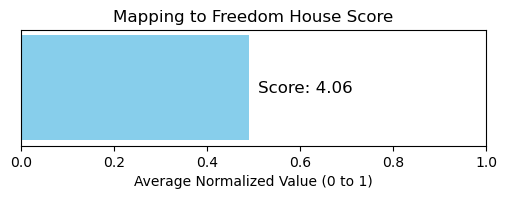

In [74]:
interactive_ui = widgets.interactive(update_freedom_house_score,
    e_gdppc=widgets.FloatSlider(min=imp["e_gdppc"].min(), max=imp["e_gdppc"].max(), step=1, value=imp["e_gdppc"].mean()),
    v2eldonate=widgets.FloatSlider(min=imp["v2eldonate"].min(), max=imp["v2eldonate"].max(), step=1, value=imp["v2eldonate"].mean()),
    v2elpubfin=widgets.FloatSlider(min=imp["v2elpubfin"].min(), max=imp["v2elpubfin"].max(), step=1, value=imp["v2elpubfin"].mean()),
    v2elembaut=widgets.FloatSlider(min=imp["v2elembaut"].min(), max=imp["v2elembaut"].max(), step=1, value=imp["v2elembaut"].mean()),
    v2elrgpwr=widgets.FloatSlider(min=imp["v2elrgpwr"].min(), max=imp["v2elrgpwr"].max(), step=1, value=imp["v2elrgpwr"].mean()),
    v2ellocpwr=widgets.FloatSlider(min=imp["v2ellocpwr"].min(), max=imp["v2ellocpwr"].max(), step=1, value=imp["v2ellocpwr"].mean()),
    v2psbars=widgets.FloatSlider(min=imp["v2psbars"].min(), max=imp["v2psbars"].max(), step=1, value=imp["v2psbars"].mean()),
    v2exrescon=widgets.FloatSlider(min=imp["v2exrescon"].min(), max=imp["v2exrescon"].max(), step=1, value=imp["v2exrescon"].mean()),
    v2cltort=widgets.FloatSlider(min=imp["v2cltort"].min(), max=imp["v2cltort"].max(), step=1, value=imp["v2cltort"].mean()),
    v2caautmob=widgets.FloatSlider(min=imp["v2caautmob"].min(), max=imp["v2caautmob"].max(), step=1, value=imp["v2caautmob"].mean())
)

In [60]:
# Display the interactive widget (works in Jupyter environments)
display(interactive_ui)

interactive(children=(FloatSlider(value=47.018074337820934, description='e_gdppc', max=98.68869366005173, min=…

In [44]:
rename_dict = {
    "e_gdppc": "GDP per Capita",
    "v2eldonate": "Disclosure of campaign donations",
    "v2elpubfin": "Public campaign finance",
    "v2elembaut": "EMB autonomy",
    "v2elrgpwr": "Regional offices relative power",
    "v2ellocpwr": "Local offices relative power",
    "v2psbars": "Barriers to parties",
    "v2exrescon": "Executive respects constitution",
    "v2cltort": "Freedom from torture",
    "v2caautmob": "Mobilization for autocracy"
}

# Original feature keys
original_features = list(rename_dict.keys())
# List of new, user-friendly labels (in the same order)
feature_labels = [rename_dict[key] for key in original_features]


In [62]:
np.random.seed(42)
imp = pd.DataFrame({key: np.random.uniform(0, 100, 100) for key in original_features})
imp = imp.rename(columns=rename_dict)

# -------------------------------
# Function to compute Freedom House Score
# -------------------------------
def compute_freedom_house_score(custom_values, dataset):
    """
    For each feature (using its user-friendly label), normalize the custom value based on the dataset's range,
    compute the average normalized value, and map it to a Freedom House score between 1 and 7.
    """
    scaled_values = {}
    for feature in feature_labels:
        min_val = dataset[feature].min()
        max_val = dataset[feature].max()
        # Avoid division by zero
        if max_val - min_val != 0:
            scaled = (custom_values[feature] - min_val) / (max_val - min_val)
        else:
            scaled = 0.5
        scaled_values[feature] = scaled
    
    avg_scaled = np.mean(list(scaled_values.values()))
    freedom_house_score = 7 - avg_scaled * 6  # Maps average (0-1) to 1-7
    return freedom_house_score, scaled_values

# -------------------------------
# Interactive update function with dynamic plots and live summary
# -------------------------------
def update_freedom_house_score(e_gdppc, v2eldonate, v2elpubfin, v2elembaut,
                               v2elrgpwr, v2ellocpwr, v2psbars, v2exrescon,
                               v2cltort, v2caautmob):
    # Map the slider inputs to user-friendly labels
    custom_values = {
        rename_dict["e_gdppc"]: e_gdppc,
        rename_dict["v2eldonate"]: v2eldonate,
        rename_dict["v2elpubfin"]: v2elpubfin,
        rename_dict["v2elembaut"]: v2elembaut,
        rename_dict["v2elrgpwr"]: v2elrgpwr,
        rename_dict["v2ellocpwr"]: v2ellocpwr,
        rename_dict["v2psbars"]: v2psbars,
        rename_dict["v2exrescon"]: v2exrescon,
        rename_dict["v2cltort"]: v2cltort,
        rename_dict["v2caautmob"]: v2caautmob
    }
    
    # Compute the Freedom House score and normalized values
    score, scaled_vals = compute_freedom_house_score(custom_values, imp)
    
    # Create a live summary interpretation based on the score
    if score < 3:
        interpretation = "Not Free: The country's institutional environment is highly restrictive."
    elif score < 5:
        interpretation = "Partly Free: The country shows mixed attributes regarding freedom."
    else:
        interpretation = "Free: The country maintains a relatively open institutional environment."
    
    summary_text = (f"Freedom House Score: {score:.2f}\n"
                    f"Interpretation: {interpretation}")
    
    # Clear previous output for real-time updating
    clear_output(wait=True)
    
    # Display the adjusted feature values
    print("Adjusted Feature Values:")
    for key in original_features:
        new_label = rename_dict[key]
        print(f"  {new_label}: {custom_values[new_label]}")
    
    print("\nNormalized Feature Values (0 to 1):")
    for feature in feature_labels:
        print(f"  {feature}_scaled: {scaled_vals[feature]:.2f}")
    
    print("\n" + summary_text)
    
    # Create dynamic plots: one for average mapping, one for individual features.
    avg_scaled = np.mean(list(scaled_vals.values()))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot 1: Horizontal bar showing the average normalized value mapping to Freedom House Score
    axs[0].barh(0, avg_scaled, height=0.4, color='skyblue')
    axs[0].set_xlim(0, 1)
    axs[0].set_yticks([])
    axs[0].set_xlabel("Average Normalized Value (0 to 1)")
    axs[0].set_title("Overall Mapping to Freedom House Score")
    axs[0].text(avg_scaled + 0.02, 0, f"Score: {score:.2f}", va='center', fontsize=12)
    
    # Plot 2: Bar chart for individual normalized feature values
    feature_names = list(scaled_vals.keys())
    feature_values = list(scaled_vals.values())
    axs[1].barh(feature_names, feature_values, color='lightgreen')
    axs[1].set_xlim(0, 1)
    axs[1].set_xlabel("Normalized Value (0 to 1)")
    axs[1].set_title("Feature Contributions")
    
    plt.tight_layout()
    plt.show()

Adjusted Feature Values:
  GDP per Capita: 47.018074337820934
  Disclosure of campaign donations: 49.78317231550229
  Public campaign finance: 51.76013307472443
  EMB autonomy: 49.11489408050343
  Regional offices relative power: 51.60458230845587
  Local offices relative power: 52.52997446673014
  Barriers to parties: 43.158644651252125
  Executive respects constitution: 52.59558517447553
  Freedom from torture: 45.57245407206461
  Mobilization for autocracy: 47.11903883860425

Normalized Feature Values (0 to 1):
  GDP per Capita_scaled: 0.47
  Disclosure of campaign donations_scaled: 0.50
  Public campaign finance_scaled: 0.52
  EMB autonomy_scaled: 0.49
  Regional offices relative power_scaled: 0.51
  Local offices relative power_scaled: 0.52
  Barriers to parties_scaled: 0.43
  Executive respects constitution_scaled: 0.52
  Freedom from torture_scaled: 0.45
  Mobilization for autocracy_scaled: 0.47

Freedom House Designation Score (1 to 7): 4.06


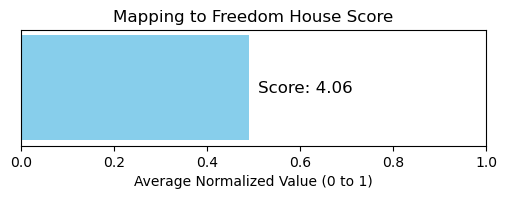

In [70]:
# -------------------------------
# Function to compute Freedom House Score
# -------------------------------
def compute_freedom_house_score(custom_values, dataset):
    """
    For each feature (using its user-friendly label), normalize the custom value based on the dataset's range,
    compute the average normalized value, and map it to a Freedom House score between 1 and 7.
    """
    scaled_values = {}
    for feature in feature_labels:
        min_val = dataset[feature].min()
        max_val = dataset[feature].max()
        # Avoid division by zero
        if max_val - min_val != 0:
            scaled = (custom_values[feature] - min_val) / (max_val - min_val)
        else:
            scaled = 0.5
        scaled_values[feature] = scaled
    
    avg_scaled = np.mean(list(scaled_values.values()))
    freedom_house_score = 7 - avg_scaled * 6
    return freedom_house_score, scaled_values

# -------------------------------
# Interactive update function
# -------------------------------
def update_freedom_house_score(e_gdppc, v2eldonate, v2elpubfin, v2elembaut,
                               v2elrgpwr, v2ellocpwr, v2psbars, v2exrescon,
                               v2cltort, v2caautmob):
    # Map the inputs to their new, user-friendly labels
    custom_values = {
        rename_dict["e_gdppc"]: e_gdppc,
        rename_dict["v2eldonate"]: v2eldonate,
        rename_dict["v2elpubfin"]: v2elpubfin,
        rename_dict["v2elembaut"]: v2elembaut,
        rename_dict["v2elrgpwr"]: v2elrgpwr,
        rename_dict["v2ellocpwr"]: v2ellocpwr,
        rename_dict["v2psbars"]: v2psbars,
        rename_dict["v2exrescon"]: v2exrescon,
        rename_dict["v2cltort"]: v2cltort,
        rename_dict["v2caautmob"]: v2caautmob
    }
    
    # Compute the Freedom House score and normalized values
    score, scaled_vals = compute_freedom_house_score(custom_values, imp)
    
    # Display the adjusted feature values using the user-friendly labels
    print("Adjusted Feature Values:")
    for old_key in original_features:
        new_label = rename_dict[old_key]
        print(f"  {new_label}: {custom_values[new_label]}")
    
    print("\nNormalized Feature Values (0 to 1):")
    for feature in feature_labels:
        print(f"  {feature}_scaled: {scaled_vals[feature]:.2f}")
    
    print(f"\nFreedom House Designation Score (1 to 7): {score:.2f}")
    
    # Visualization: Horizontal bar chart showing the average normalized value
    avg_scaled = np.mean(list(scaled_vals.values()))
    fig, ax = plt.subplots(figsize=(6, 1.5))
    ax.barh(0, avg_scaled, height=0.4, color='skyblue')
    ax.set_xlim(0, 1)
    ax.set_yticks([])
    ax.set_xlabel("Average Normalized Value (0 to 1)")
    ax.set_title("Mapping to Freedom House Score")
    
    # Annotate with the computed score
    mapped_value = 7 - avg_scaled * 6
    ax.text(avg_scaled + 0.02, 0, f"Score: {mapped_value:.2f}", va='center', fontsize=12)
    plt.show()

# -------------------------------
# Create interactive sliders for each feature
# -------------------------------
interactive_ui = widgets.interactive(update_freedom_house_score,
    e_gdppc=widgets.FloatSlider(
        min=imp[rename_dict["e_gdppc"]].min(), 
        max=imp[rename_dict["e_gdppc"]].max(), 
        step=1, 
        value=imp[rename_dict["e_gdppc"]].mean(),
        description=rename_dict["e_gdppc"]
    ),
    v2eldonate=widgets.FloatSlider(
        min=imp[rename_dict["v2eldonate"]].min(), 
        max=imp[rename_dict["v2eldonate"]].max(), 
        step=1, 
        value=imp[rename_dict["v2eldonate"]].mean(),
        description=rename_dict["v2eldonate"]
    ),
    v2elpubfin=widgets.FloatSlider(
        min=imp[rename_dict["v2elpubfin"]].min(), 
        max=imp[rename_dict["v2elpubfin"]].max(), 
        step=1, 
        value=imp[rename_dict["v2elpubfin"]].mean(),
        description=rename_dict["v2elpubfin"]
    ),
    v2elembaut=widgets.FloatSlider(
        min=imp[rename_dict["v2elembaut"]].min(), 
        max=imp[rename_dict["v2elembaut"]].max(), 
        step=1, 
        value=imp[rename_dict["v2elembaut"]].mean(),
        description=rename_dict["v2elembaut"]
    ),
    v2elrgpwr=widgets.FloatSlider(
        min=imp[rename_dict["v2elrgpwr"]].min(), 
        max=imp[rename_dict["v2elrgpwr"]].max(), 
        step=1, 
        value=imp[rename_dict["v2elrgpwr"]].mean(),
        description=rename_dict["v2elrgpwr"]
    ),
    v2ellocpwr=widgets.FloatSlider(
        min=imp[rename_dict["v2ellocpwr"]].min(), 
        max=imp[rename_dict["v2ellocpwr"]].max(), 
        step=1, 
        value=imp[rename_dict["v2ellocpwr"]].mean(),
        description=rename_dict["v2ellocpwr"]
    ),
    v2psbars=widgets.FloatSlider(
        min=imp[rename_dict["v2psbars"]].min(), 
        max=imp[rename_dict["v2psbars"]].max(), 
        step=1, 
        value=imp[rename_dict["v2psbars"]].mean(),
        description=rename_dict["v2psbars"]
    ),
    v2exrescon=widgets.FloatSlider(
        min=imp[rename_dict["v2exrescon"]].min(), 
        max=imp[rename_dict["v2exrescon"]].max(), 
        step=1, 
        value=imp[rename_dict["v2exrescon"]].mean(),
        description=rename_dict["v2exrescon"]
    ),
    v2cltort=widgets.FloatSlider(
        min=imp[rename_dict["v2cltort"]].min(), 
        max=imp[rename_dict["v2cltort"]].max(), 
        step=1, 
        value=imp[rename_dict["v2cltort"]].mean(),
        description=rename_dict["v2cltort"]
    ),
    v2caautmob=widgets.FloatSlider(
        min=imp[rename_dict["v2caautmob"]].min(), 
        max=imp[rename_dict["v2caautmob"]].max(), 
        step=1, 
        value=imp[rename_dict["v2caautmob"]].mean(),
        description=rename_dict["v2caautmob"]
    )
)

In [66]:
display(interactive_ui)

interactive(children=(FloatSlider(value=47.018074337820934, description='GDP per Capita', max=98.6886936600517…